# 1. Import Libraries 

In [1]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import MDS, TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'
kg_vec = 200

In [2]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [3]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'DBpedia', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom Animal Attribute + Taxonomy KG" - Custom KGs
#4. "Word2Vec" - word2vec-google-news-300
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)

Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Dbnary Animal Attributes Included
Execution time: 8.446148157119751 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [4]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [5]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,-kg_vec:]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,-kg_vec:]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,-kg_vec:]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,-kg_vec:]

In [6]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [7]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [8]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [9]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

In [10]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

In [11]:
class ProjectionNetwork3(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork3, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, num_units) 
        self.fc4 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [12]:
# Create Skorch EPOCHScoring   
train_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'train_recall_macro', on_train = True)
valid_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'valid_recall_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### 7.4 Define Conventiona Zero Shot Leaning Function

In [14]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, pred_type, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    net = NeuralNetClassifier(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_macro_recall_score,valid_macro_recall_score, checkpoint],
    callbacks__valid_acc=None,
    device= device
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #Plot training val curves
    print('Training Validation Loss Curve')
    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Error Loss', fontsize=10)
    plt.legend()
    plt.show() 
    
    print('Trianing Recall Macro Curve')
    train_loss = net.history[:, 'train_recall_macro']
    valid_loss = net.history[:, 'valid_recall_macro']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('F1 Score (Macro)', fontsize=10)
    plt.legend()
    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)  
 
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = net.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction DNN performance
        #print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=animal_attributes_list))    
        
        print("Recall (Macro)")
        print(recall_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, average='macro'))
    
    if mode == "Test":
        pass

    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = net.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,-kg_vec:])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=0, random_state=123, perplexity=9.0)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseenprob = []
    for y in y_pred_unseen_proba:
        y_pred_unseenprob.append(y[1])
        
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseenprob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction)
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'])
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

# 8. Train Model

### 8.1 Train Validation Split 01

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4619                0.5233        0.4404                0.5286     +  2.6842
      2        0.4229                0.5425        0.4032                0.5618     +  1.3101
      3        0.3824                0.5796        0.3616                0.6011     +  1.2895
      4        0.3435                0.6156        0.3261                0.6370     +  1.3172
      5        0.3112                0.6560        0.2970                0.6780     +  1.3443
      6        0.2841                0.6935        0.2727                0.7124     +  1.3320
      7        0.2614                0.7268        0.2522                0.7412     +  1.2681
      8        0.2418                0.7545        0.2348                0.7671     +  1.2794
      9        0.2252                0.7772    

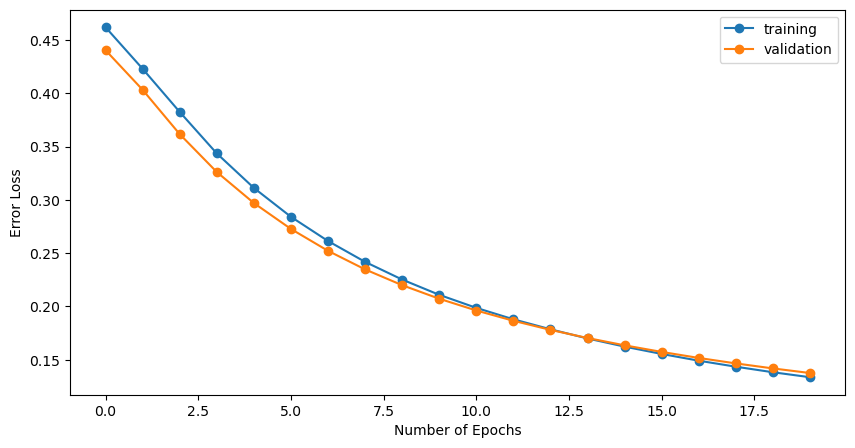

Trianing Recall Macro Curve


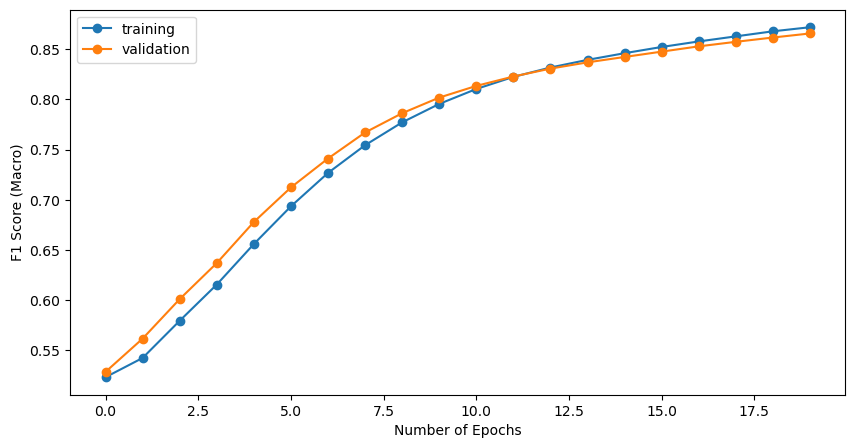

Recall (Macro)
0.867890174765866
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.00      0.00      0.00       152
   dalmatian       0.02      0.01      0.01       442
        mole       0.00      0.00      0.00        75
     leopard       0.02      0.09      0.03       568
       moose       0.03      0.01      0.01       554
     gorilla       0.00      0.00      0.00       709
          ox       0.00      0.00      0.00       588
  chimpanzee       0.04      0.09      0.05       566
     hamster       0.00      0.00      0.00       640
      rabbit       0.00      0.00      0.00       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.02      0.01      0.01      1069
     raccoon       0.01      0.04      0.02       408

    accuracy                           0.02      7340
   macro avg       0.01      0.02      0.01      7340
weighted avg       0.01      0.02      0.01      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.013574

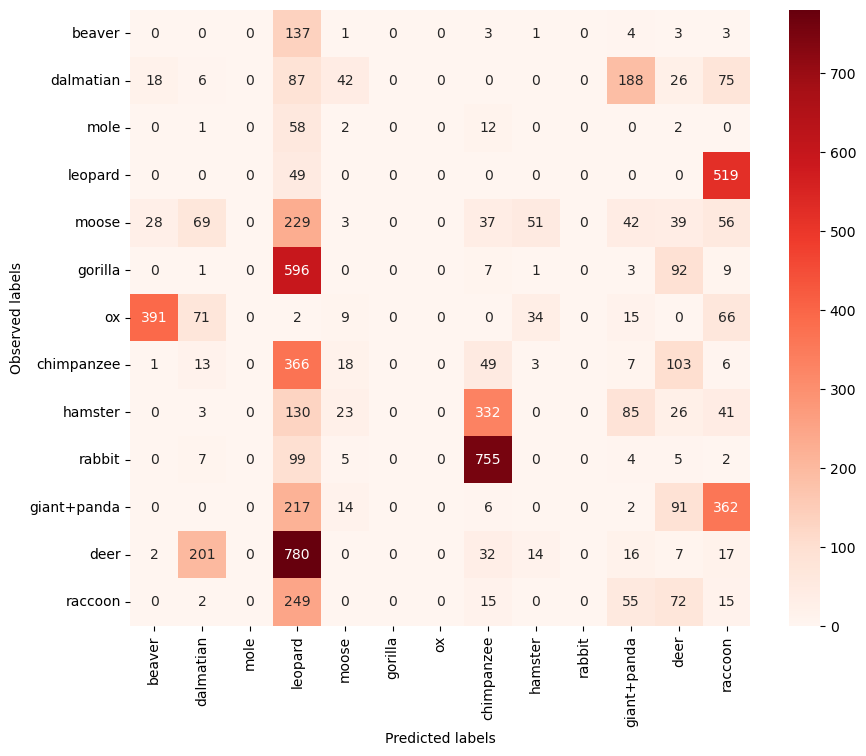

              precision    recall  f1-score   support

ARTIODACTYLA       0.10      0.03      0.04      2211
   CARNIVORA       0.37      0.87      0.52      2110
EULIPOTYPHLA       0.00      0.00      0.00        75
  LAGOMORPHA       0.00      0.00      0.00       877
    PRIMATES       0.04      0.04      0.04      1275
    RODENTIA       0.00      0.00      0.00       792

    accuracy                           0.26      7340
   macro avg       0.09      0.16      0.10      7340
weighted avg       0.14      0.26      0.17      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.02623247 0.86540284 0.         0.         0.04392157 0.00126263]
Top_1_accuracy for UnSeen Validation split 01 -  0.15613658541427353


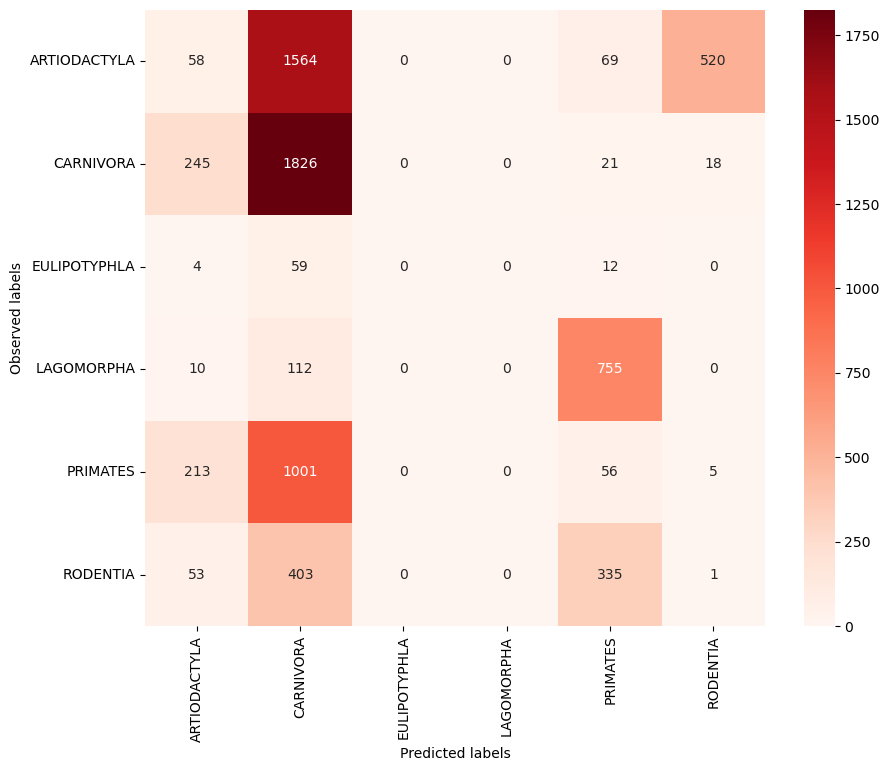

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.06671699404102778 
              0         1
0        beaver  0.000000
1     dalmatian  0.031674
2          mole  0.000000
3       leopard  0.353873
4         moose  0.028881
5       gorilla  0.000000
6            ox  0.000000
7    chimpanzee  0.273852
8       hamster  0.000000
9        rabbit  0.000000
10  giant+panda  0.057803
11         deer  0.047708
12      raccoon  0.073529 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.12411847647798122 
              0         1
0        beaver  0.000000
1     dalmatian  0.079186
2          mole  0.000000
3       leopard  0.547535
4         moose  0.050542
5       gorilla  0.001410
6            ox  0.000000
7    chimpanzee  0.480565
8       hamster  0.000000
9        rabbit  0.000000
10  giant+panda  0.212428
11         deer  0.148737
12      raccoon  0.093137 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.1990580888548547 
              0         1
0        beaver  0.000000
1   

In [15]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.2 Train Validation Split 02

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4361                0.5228        0.4136                0.5290     +  1.3274
      2        0.3999                0.5398        0.3815                0.5526     +  1.0888
      3        0.3647                0.5685        0.3444                0.5825     +  1.3124
      4        0.3290                0.6043        0.3102                0.6235     +  1.2910
      5        0.2970                0.6487        0.2812                0.6705     +  1.3063
      6        0.2699                0.6930        0.2568                0.7123     +  1.3428
      7        0.2470                0.7306        0.2361                0.7467     +  1.2937
      8        0.2271                0.7618        0.2185                0.7758     +  1.3114
      9        0.2104                0.7871    

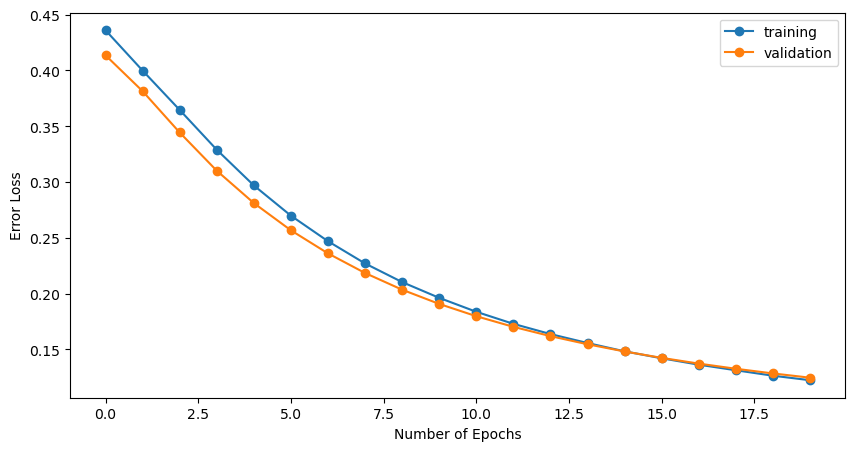

Trianing Recall Macro Curve


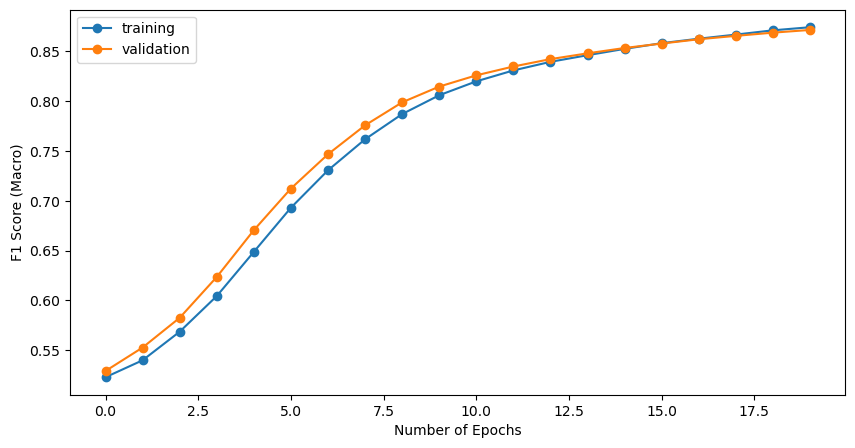

Recall (Macro)
0.8742139130170898
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.00      0.00      0.00       864
grizzly+bear       0.02      0.00      0.01       690
killer+whale       0.00      0.00      0.00       231
      beaver       0.00      0.00      0.00       152
   dalmatian       0.28      0.10      0.15       442
 persian+cat       0.04      0.13      0.06       599
       skunk       0.04      0.43      0.07       157
          ox       0.00      0.00      0.00       588
         fox       0.00      0.00      0.00       540
   chihuahua       0.00      0.00      0.00       448
       otter       0.19      0.54      0.28       592
       zebra       0.00      0.00      0.00       942
         pig       0.03      0.03      0.03       558

    accuracy                           0.08      6803
   macro avg       0.05      0.10      0.05      6803
weighted avg       0.04      0.08      0.04      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.002898

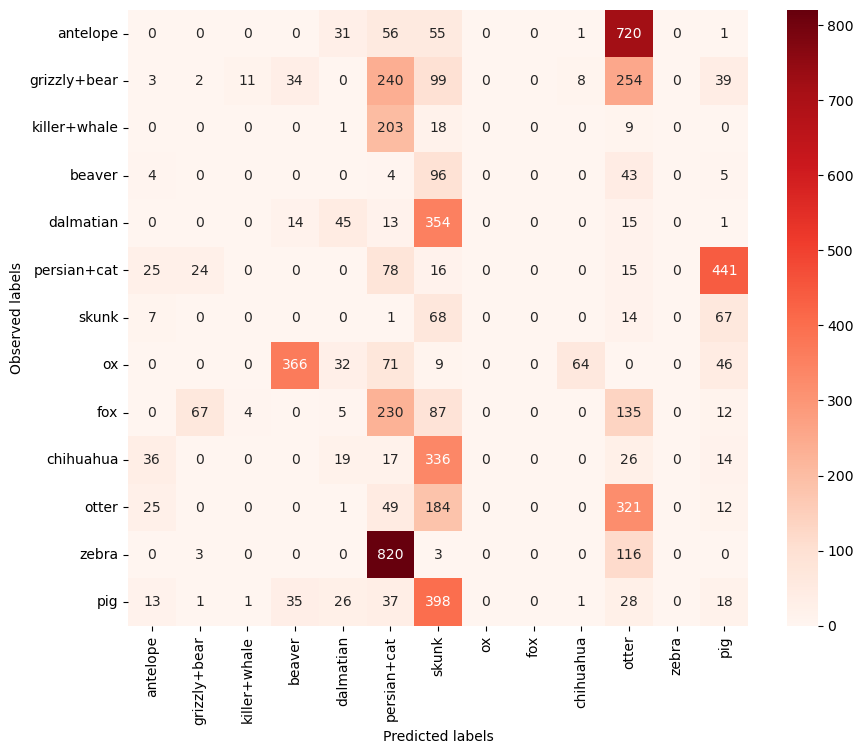

                precision    recall  f1-score   support

  ARTIODACTYLA       0.10      0.04      0.05      2241
     CARNIVORA       0.49      0.79      0.60      3468
PERISSODACTYLA       0.00      0.00      0.00       942
      RODENTIA       0.00      0.00      0.00       152

      accuracy                           0.41      6803
     macro avg       0.15      0.21      0.16      6803
  weighted avg       0.28      0.41      0.32      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.03525212 0.78517878 0.         0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.2051077242456948


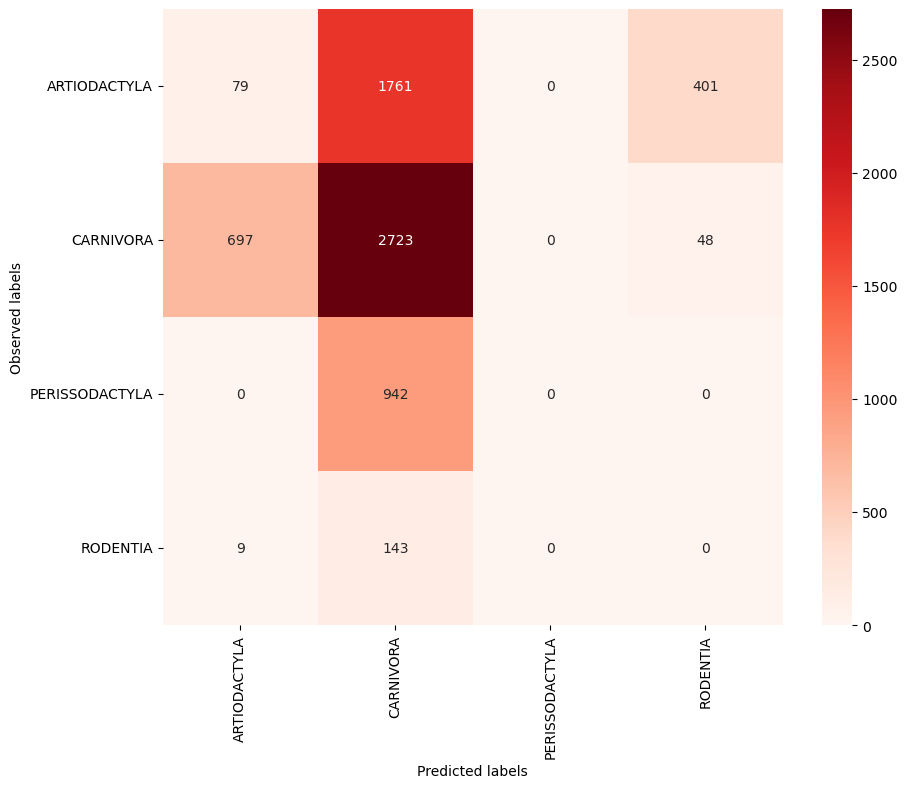

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.2085566166768803 
               0         1
0       antelope  0.000000
1   grizzly+bear  0.008696
2   killer+whale  0.000000
3         beaver  0.006579
4      dalmatian  0.540724
5    persian+cat  0.437396
6          skunk  0.872611
7             ox  0.000000
8            fox  0.000000
9      chihuahua  0.000000
10         otter  0.775338
11         zebra  0.000000
12           pig  0.069892 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.2682842900418073 
               0         1
0       antelope  0.001157
1   grizzly+bear  0.017391
2   killer+whale  0.000000
3         beaver  0.006579
4      dalmatian  0.823529
5    persian+cat  0.637730
6          skunk  0.968153
7             ox  0.000000
8            fox  0.000000
9      chihuahua  0.004464
10         otter  0.940878
11         zebra  0.000000
12           pig  0.087814 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.31170664183019353 
               0         1
0 

In [16]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.3 Train Validation Split 03

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4433                0.5100        0.4181                0.5144     +  1.3534
      2        0.4019                0.5298        0.3790                0.5431     +  1.2360
      3        0.3592                0.5713        0.3378                0.5903     +  1.1758
      4        0.3215                0.6113        0.3047                0.6254     +  1.1702
      5        0.2908                0.6428        0.2772                0.6529     +  1.1715
      6        0.2649                0.6703        0.2536                0.6800     +  1.2282
      7        0.2427                0.6990        0.2333                0.7119     +  1.2064
      8        0.2235                0.7309        0.2158                0.7447     +  1.1621
      9        0.2070                0.7619    

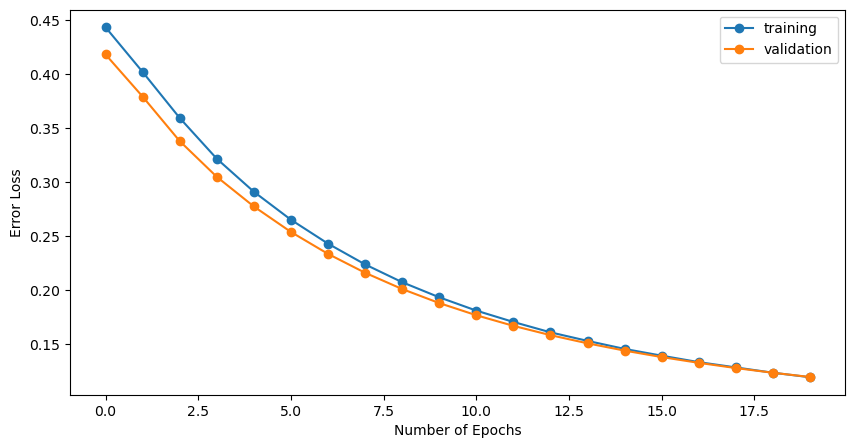

Trianing Recall Macro Curve


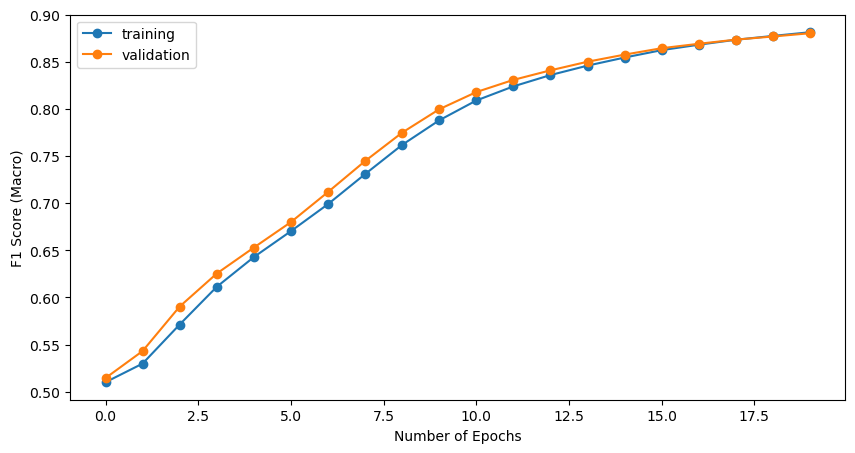

Recall (Macro)
0.8747235749747254
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.00      0.00      0.00       400
         moose       0.03      0.00      0.01       554
humpback+whale       0.00      0.00      0.00       565
    chimpanzee       0.02      0.08      0.04       566
      squirrel       0.11      0.10      0.10       961
    rhinoceros       0.00      0.00      0.00       561
        rabbit       0.00      0.00      0.00       877
          wolf       0.06      0.01      0.01       470
     chihuahua       0.08      0.09      0.08       448
        weasel       0.00      0.01      0.00       222
   giant+panda       0.03      0.07      0.04       692
           pig       1.00      0.00      0.00       558
       raccoon       0.00      0.00      0.00       408

      accuracy                           0.03      7282
     macro avg       0.10      0.03      0.02      7282
  weighted avg       0.11      0.03      0.03      7282

Top_1_accuracy for UnSeen Validation split 01

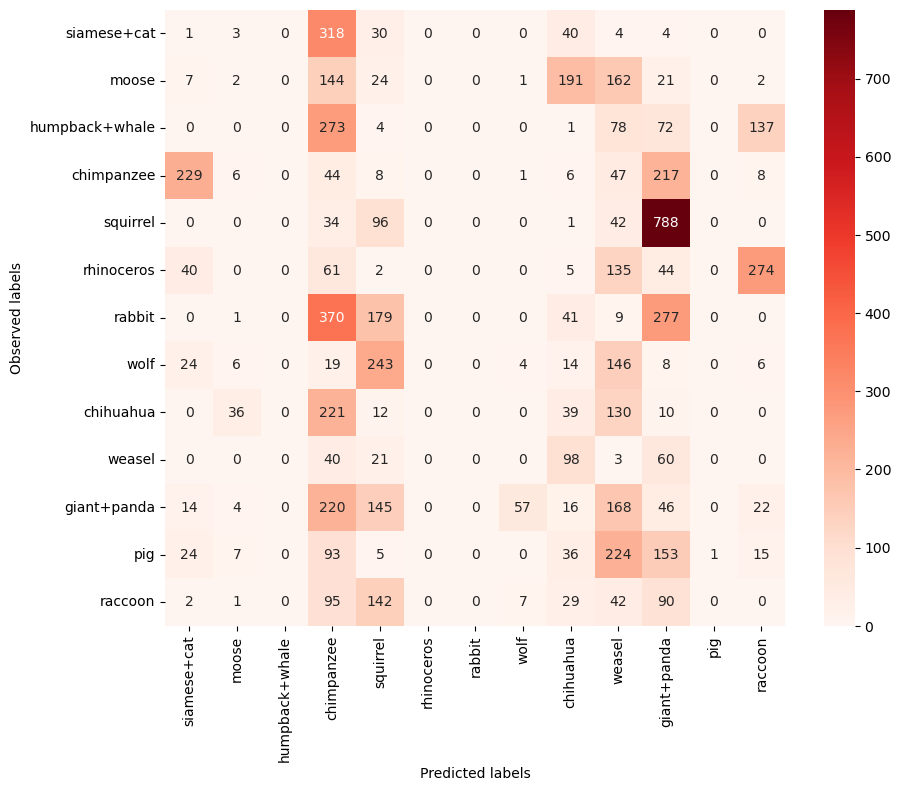

                precision    recall  f1-score   support

  ARTIODACTYLA       0.15      0.01      0.01      1677
     CARNIVORA       0.25      0.41      0.31      2640
    LAGOMORPHA       0.00      0.00      0.00       877
PERISSODACTYLA       0.00      0.00      0.00       561
      PRIMATES       0.02      0.08      0.04       566
      RODENTIA       0.11      0.10      0.10       961

      accuracy                           0.17      7282
     macro avg       0.09      0.10      0.08      7282
  weighted avg       0.14      0.17      0.13      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.00596303 0.41060606 0.         0.         0.07773852 0.09989594]
Top_1_accuracy for UnSeen Validation split 01 -  0.0990339245755552


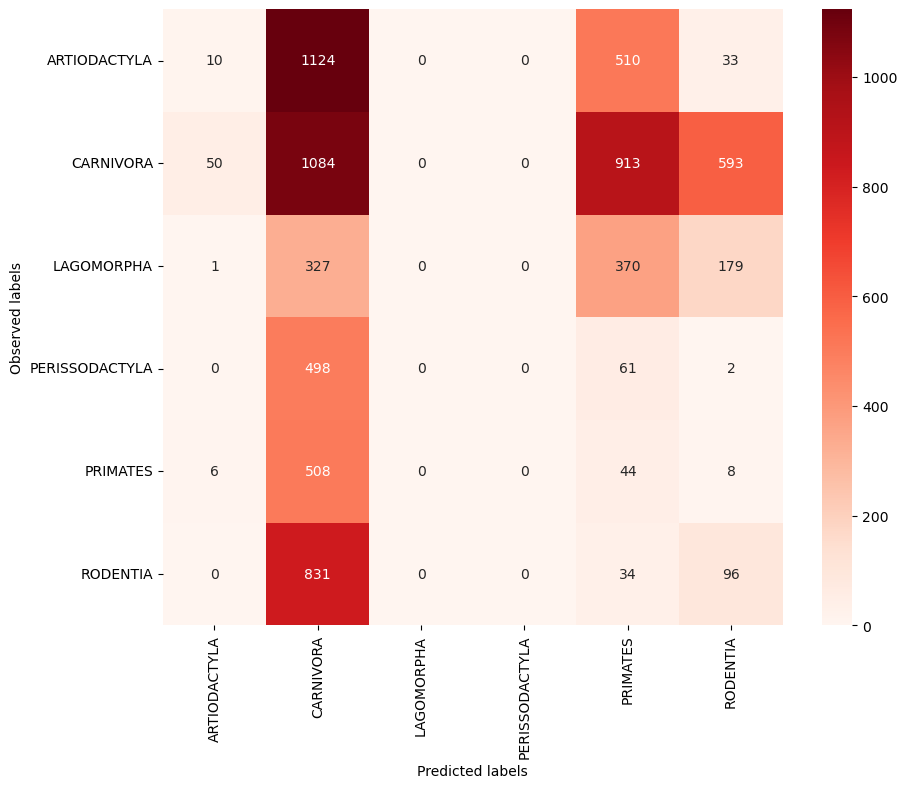

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.08849784650041262 
                 0         1
0      siamese+cat  0.002500
1            moose  0.021661
2   humpback+whale  0.000000
3       chimpanzee  0.121908
4         squirrel  0.443288
5       rhinoceros  0.000000
6           rabbit  0.000000
7             wolf  0.014894
8        chihuahua  0.263393
9           weasel  0.067568
10     giant+panda  0.208092
11             pig  0.007168
12         raccoon  0.000000 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.16502491902630195 
                 0         1
0      siamese+cat  0.002500
1            moose  0.050542
2   humpback+whale  0.000000
3       chimpanzee  0.167845
4         squirrel  0.892820
5       rhinoceros  0.000000
6           rabbit  0.000000
7             wolf  0.023404
8        chihuahua  0.426339
9           weasel  0.162162
10     giant+panda  0.408960
11             pig  0.010753
12         raccoon  0.000000 

 Top- 4  Accuracy per class 
 Top- 4  Accu

In [17]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 9. Hyperoptimisation

In [19]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, kg_vec))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 4, 64)
    ep = trial.suggest_int("max_epoch", 5, 50)
    mom = trial.suggest_loguniform('optimizer__momentum', .90, .99)
   
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict_proba(ValData01.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob1 = []
    for y in y_pred_unseen1:
        y_pred_unseen_prob1.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,-kg_vec:])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen_prob1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict_proba(ValData02.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob2 = []
    for y in y_pred_unseen2:
        y_pred_unseen_prob2.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,-kg_vec:])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen_prob2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict_proba(ValData03.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob3 = []
    for y in y_pred_unseen3:
        y_pred_unseen_prob3.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,-kg_vec:])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen_prob3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [20]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="DNN with KG.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-08 21:30:40,732] A new study created in memory with name: no-name-921b4475-7c4f-47e9-a967-6aaf45bfc9e8


Sequential(
  (0): Linear(in_features=2048, out_features=213, bias=True)
  (1): Dropout(p=0.20967408184262137, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=213, out_features=998, bias=True)
  (4): Dropout(p=0.20967408184262137, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=998, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=213, bias=True)
  (1): Dropout(p=0.20967408184262137, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=213, out_features=998, bias=True)
  (4): Dropout(p=0.20967408184262137, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=998, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=213, bias=True)
  (1): Dropout(p=0.20967408184262137, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=213, out_features=998, bias=True)
  (4): Dropout(p=0.20967408184262137, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=998, out_features=200, bias=True)
)
  epoch    tr

[I 2022-12-08 21:31:34,219] Trial 0 finished with value: 0.04001315763505447 and parameters: {'lr': 0.11345724863324479, 'batch_size': 35, 'max_epoch': 20, 'optimizer__momentum': 0.9187400332354023, 'n_layers': 2, 'dropout': 0.20967408184262137, 'n_units_l0': 213, 'n_units_l1': 998}. Best is trial 0 with value: 0.04001315763505447.


[0.01149389189742615, 0.054897045543267055, 0.05364853546447019]
Sequential(
  (0): Linear(in_features=2048, out_features=43, bias=True)
  (1): Dropout(p=0.18096871573648787, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=43, out_features=21, bias=True)
  (4): Dropout(p=0.18096871573648787, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=21, out_features=5, bias=True)
  (7): Dropout(p=0.18096871573648787, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=5, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=43, bias=True)
  (1): Dropout(p=0.18096871573648787, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=43, out_features=21, bias=True)
  (4): Dropout(p=0.18096871573648787, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=21, out_features=5, bias=True)
  (7): Dropout(p=0.18096871573648787, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=5, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2

[I 2022-12-08 21:32:38,461] Trial 1 finished with value: 0.036688183234971354 and parameters: {'lr': 0.013785014656476023, 'batch_size': 33, 'max_epoch': 21, 'optimizer__momentum': 0.9449734129567486, 'n_layers': 3, 'dropout': 0.18096871573648787, 'n_units_l0': 43, 'n_units_l1': 21, 'n_units_l2': 5}. Best is trial 0 with value: 0.04001315763505447.


[0.020036742117010894, 0.059575101392108226, 0.03045270619579495]
Sequential(
  (0): Linear(in_features=2048, out_features=304, bias=True)
  (1): Dropout(p=0.31829285864855794, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=304, out_features=883, bias=True)
  (4): Dropout(p=0.31829285864855794, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=883, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=304, bias=True)
  (1): Dropout(p=0.31829285864855794, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=304, out_features=883, bias=True)
  (4): Dropout(p=0.31829285864855794, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=883, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=304, bias=True)
  (1): Dropout(p=0.31829285864855794, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=304, out_features=883, bias=True)
  (4): Dropout(p=0.31829285864855794, inplace=False)
  (5): ReLU()
  (6): Li

     15        0.0148        0.0548                0.9440  0.9385
     16        0.0167        0.0541                0.9447  0.8830
     17        0.0144        0.0572                0.9396  0.9639
     18        0.0147        0.0553                0.9435  0.9499
     19        0.0143        0.0574                0.9446  0.9319
     20        0.0122        0.0569                0.9457  0.8702
     21        0.0115        0.0560                0.9441  0.8945
     22        0.0111        0.0583                0.9423  0.8845
     23        0.0096        0.0602                0.9420  0.9345
     24        0.0094        0.0670                0.9453  0.9199
     25        0.0117        0.0663                0.9445  0.9188
     26        0.0109        0.0622                0.9444  0.8813
     27        0.0082        0.0638                0.9404  0.8763
     28        0.0084        0.0651                0.9433  0.8445
     29        0.0081        0.0652                0.9411  0.9043
     30   

[I 2022-12-08 21:34:40,341] Trial 2 finished with value: 0.03605724248082964 and parameters: {'lr': 0.1597521841257083, 'batch_size': 27, 'max_epoch': 38, 'optimizer__momentum': 0.9505813240346133, 'n_layers': 2, 'dropout': 0.31829285864855794, 'n_units_l0': 304, 'n_units_l1': 883}. Best is trial 0 with value: 0.04001315763505447.


[0.017487819354811196, 0.02848188240952316, 0.06220202567815458]
Sequential(
  (0): Linear(in_features=2048, out_features=11, bias=True)
  (1): Dropout(p=0.40458216516857026, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=11, out_features=4, bias=True)
  (4): Dropout(p=0.40458216516857026, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=11, bias=True)
  (1): Dropout(p=0.40458216516857026, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=11, out_features=4, bias=True)
  (4): Dropout(p=0.40458216516857026, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=11, bias=True)
  (1): Dropout(p=0.40458216516857026, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=11, out_features=4, bias=True)
  (4): Dropout(p=0.40458216516857026, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=

[I 2022-12-08 21:35:19,625] Trial 3 finished with value: 0.05754239932542433 and parameters: {'lr': 0.2014563222508859, 'batch_size': 31, 'max_epoch': 14, 'optimizer__momentum': 0.9247884881951082, 'n_layers': 2, 'dropout': 0.40458216516857026, 'n_units_l0': 11, 'n_units_l1': 4}. Best is trial 3 with value: 0.05754239932542433.


[0.02058882471193125, 0.11300994554333452, 0.039028427721007224]
Sequential(
  (0): Linear(in_features=2048, out_features=45, bias=True)
  (1): Dropout(p=0.4269180855766407, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=45, out_features=14, bias=True)
  (4): Dropout(p=0.4269180855766407, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=14, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=45, bias=True)
  (1): Dropout(p=0.4269180855766407, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=45, out_features=14, bias=True)
  (4): Dropout(p=0.4269180855766407, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=14, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=45, bias=True)
  (1): Dropout(p=0.4269180855766407, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=45, out_features=14, bias=True)
  (4): Dropout(p=0.4269180855766407, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=1

     25        0.3074        0.2501                0.6795  0.5205


[I 2022-12-08 21:36:13,183] Trial 4 finished with value: 0.06035380890409613 and parameters: {'lr': 0.008719169541078596, 'batch_size': 56, 'max_epoch': 25, 'optimizer__momentum': 0.9625301565875575, 'n_layers': 2, 'dropout': 0.4269180855766407, 'n_units_l0': 45, 'n_units_l1': 14}. Best is trial 4 with value: 0.06035380890409613.


[0.020053103452413457, 0.11981502630006949, 0.04119329695980545]
Sequential(
  (0): Linear(in_features=2048, out_features=11, bias=True)
  (1): Dropout(p=0.31215426265035706, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=11, out_features=4, bias=True)
  (4): Dropout(p=0.31215426265035706, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=11, bias=True)
  (1): Dropout(p=0.31215426265035706, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=11, out_features=4, bias=True)
  (4): Dropout(p=0.31215426265035706, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=11, bias=True)
  (1): Dropout(p=0.31215426265035706, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=11, out_features=4, bias=True)
  (4): Dropout(p=0.31215426265035706, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=

     16        0.4693        0.4196                0.4940  0.5755
     17        0.4687        0.4181                0.4960  0.5643
     18        0.4658        0.4164                0.4988  0.5679
     19        0.4650        0.4139                0.5017  0.5692
     20        0.4623        0.4132                0.5038  0.5695
     21        0.4592        0.4130                0.5062  0.5696
     22        0.4587        0.4113                0.5079  0.5743
     23        0.4558        0.4083                0.5078  0.5725
     24        0.4543        0.4077                0.5107  0.5657
     25        0.4528        0.4061                0.5121  0.6828
     26        0.4507        0.4049                0.5119  0.6588
     27        0.4490        0.4040                0.5138  0.6965
     28        0.4498        0.4024                0.5165  0.6823
     29        0.4468        0.4017                0.5165  0.7017
     30        0.4448        0.3999                0.5173  0.7047
     31   

[I 2022-12-08 21:37:21,464] Trial 5 finished with value: 0.06396220532408925 and parameters: {'lr': 0.004220257255420379, 'batch_size': 43, 'max_epoch': 31, 'optimizer__momentum': 0.9671527967112312, 'n_layers': 2, 'dropout': 0.31215426265035706, 'n_units_l0': 11, 'n_units_l1': 4}. Best is trial 5 with value: 0.06396220532408925.


[0.03495740351138294, 0.12265873649429576, 0.03427047596658905]
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.33401468018301217, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=5, bias=True)
  (4): Dropout(p=0.33401468018301217, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.33401468018301217, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=5, bias=True)
  (4): Dropout(p=0.33401468018301217, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.33401468018301217, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=5, bias=True)
  (4): Dropout(p=0.33401468018301217, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=5, out_

     31        0.4435        0.4427                0.5000  1.4731
     32        0.4435        0.4427                0.5000  1.5593


[I 2022-12-08 21:39:44,854] Trial 6 finished with value: 0.07692307692307693 and parameters: {'lr': 0.4753993508431557, 'batch_size': 17, 'max_epoch': 32, 'optimizer__momentum': 0.9568309306033719, 'n_layers': 2, 'dropout': 0.33401468018301217, 'n_units_l0': 7, 'n_units_l1': 5}. Best is trial 6 with value: 0.07692307692307693.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=181, bias=True)
  (1): Dropout(p=0.2985286787740644, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=181, out_features=222, bias=True)
  (4): Dropout(p=0.2985286787740644, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=222, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=181, bias=True)
  (1): Dropout(p=0.2985286787740644, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=181, out_features=222, bias=True)
  (4): Dropout(p=0.2985286787740644, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=222, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=181, bias=True)
  (1): Dropout(p=0.2985286787740644, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=181, out_features=222, bias=True)
  (4): Dropout(p=0.2985286787740644, inplace=False)
  (5): ReLU()
  (6): Linear(in_

     30        0.0980        0.0834                0.8960  1.0394
     31        0.0946        0.0811                0.8971  1.1729
     32        0.0917        0.0792                0.8982  1.0993
     33        0.0890        0.0773                0.8995  1.1525
     34        0.0874        0.0756                0.9004  1.1323
     35        0.0842        0.0741                0.9013  1.3130
     36        0.0822        0.0725                0.9018  1.1186
     37        0.0799        0.0711                0.9027  1.0335
     38        0.0781        0.0700                0.9029  1.2313
     39        0.0767        0.0687                0.9039  1.0956
     40        0.0745        0.0675                0.9043  1.0389
     41        0.0726        0.0665                0.9052  1.0331
     42        0.0708        0.0655                0.9055  1.0649
     43        0.0696        0.0645                0.9061  1.0125
     44        0.0681        0.0637                0.9064  1.1013
     45   

[I 2022-12-08 21:42:43,244] Trial 7 finished with value: 0.04074842859988393 and parameters: {'lr': 0.002660514638954389, 'batch_size': 20, 'max_epoch': 46, 'optimizer__momentum': 0.9068435610139051, 'n_layers': 2, 'dropout': 0.2985286787740644, 'n_units_l0': 181, 'n_units_l1': 222}. Best is trial 6 with value: 0.07692307692307693.


[0.0152253400986491, 0.06323643558961461, 0.043783510111388084]
Sequential(
  (0): Linear(in_features=2048, out_features=78, bias=True)
  (1): Dropout(p=0.4829624142307739, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=78, out_features=130, bias=True)
  (4): Dropout(p=0.4829624142307739, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=130, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=78, bias=True)
  (1): Dropout(p=0.4829624142307739, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=78, out_features=130, bias=True)
  (4): Dropout(p=0.4829624142307739, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=130, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=78, bias=True)
  (1): Dropout(p=0.4829624142307739, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=78, out_features=130, bias=True)
  (4): Dropout(p=0.4829624142307739, inplace=False)
  (5): ReLU()
  (6): Linear(in_featur

[I 2022-12-08 21:43:26,755] Trial 8 finished with value: 0.04148867655960272 and parameters: {'lr': 0.05289276557989898, 'batch_size': 52, 'max_epoch': 19, 'optimizer__momentum': 0.9090772364228601, 'n_layers': 2, 'dropout': 0.4829624142307739, 'n_units_l0': 78, 'n_units_l1': 130}. Best is trial 6 with value: 0.07692307692307693.


[0.021156465410230127, 0.04292848341934893, 0.06038108084922911]
Sequential(
  (0): Linear(in_features=2048, out_features=80, bias=True)
  (1): Dropout(p=0.4710002482802186, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=80, out_features=82, bias=True)
  (4): Dropout(p=0.4710002482802186, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=82, out_features=166, bias=True)
  (7): Dropout(p=0.4710002482802186, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=166, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=80, bias=True)
  (1): Dropout(p=0.4710002482802186, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=80, out_features=82, bias=True)
  (4): Dropout(p=0.4710002482802186, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=82, out_features=166, bias=True)
  (7): Dropout(p=0.4710002482802186, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=166, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features

[I 2022-12-08 21:43:52,441] Trial 9 finished with value: 0.06306271749363829 and parameters: {'lr': 0.7841367848333076, 'batch_size': 63, 'max_epoch': 11, 'optimizer__momentum': 0.9651077385322769, 'n_layers': 3, 'dropout': 0.4710002482802186, 'n_units_l0': 80, 'n_units_l1': 82, 'n_units_l2': 166}. Best is trial 6 with value: 0.07692307692307693.


[0.03534199863476099, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=5, bias=True)
  (1): Dropout(p=0.25446971139253366, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=5, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=5, bias=True)
  (1): Dropout(p=0.25446971139253366, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=5, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=5, bias=True)
  (1): Dropout(p=0.25446971139253366, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=5, out_features=200, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4692        0.4658                0.5250  4.8479
      2        0.4658        0.4658                0.5250  4.7124
      3        0.4658        0.4658                0.5250  4.8364
      4     

[I 2022-12-08 21:45:04,428] Trial 10 finished with value: 0.07692307692307693 and parameters: {'lr': 0.9292755669033776, 'batch_size': 4, 'max_epoch': 5, 'optimizer__momentum': 0.9860721648778155, 'n_layers': 1, 'dropout': 0.25446971139253366, 'n_units_l0': 5}. Best is trial 6 with value: 0.07692307692307693.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=4, bias=True)
  (1): Dropout(p=0.10763326200242287, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=4, bias=True)
  (1): Dropout(p=0.10763326200242287, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=4, bias=True)
  (1): Dropout(p=0.10763326200242287, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=200, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4684        0.4654                0.5250  4.0180
      2        0.4650        0.4654                0.5250  3.7302
      3        0.4649        0.4653                0.5250  3.6469
      4     

[I 2022-12-08 21:46:17,634] Trial 11 finished with value: 0.07692307692307693 and parameters: {'lr': 0.7921410907915958, 'batch_size': 4, 'max_epoch': 6, 'optimizer__momentum': 0.9840054634372782, 'n_layers': 1, 'dropout': 0.10763326200242287, 'n_units_l0': 4}. Best is trial 6 with value: 0.07692307692307693.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=1659, bias=True)
  (1): Dropout(p=0.24037488083018402, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1659, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1659, bias=True)
  (1): Dropout(p=0.24037488083018402, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1659, out_features=200, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1659, bias=True)
  (1): Dropout(p=0.24037488083018402, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1659, out_features=200, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4403        0.4847                0.6107  5.1834
      2        0.4719        0.4330                0.5542  5.2519
      3        0.4287        0.4204                0.5706  5

[I 2022-12-08 21:55:47,683] Trial 12 finished with value: 0.07688027053636402 and parameters: {'lr': 0.3920283307304657, 'batch_size': 4, 'max_epoch': 35, 'optimizer__momentum': 0.9807339660312958, 'n_layers': 1, 'dropout': 0.24037488083018402, 'n_units_l0': 1659}. Best is trial 6 with value: 0.07692307692307693.


[0.07692307692307693, 0.07679465776293823, 0.07692307692307693]
Number of finished trials: 13
Best trial:
  Value: 0.07692307692307693
  Params: 
    lr: 0.4753993508431557
    batch_size: 17
    max_epoch: 32
    optimizer__momentum: 0.9568309306033719
    n_layers: 2
    dropout: 0.33401468018301217
    n_units_l0: 7
    n_units_l1: 5


# 10. CZSL on Unseen Test Set using Hyperoptiimsation parameters

In [21]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, 7)  
        self.fc2 = nn.Linear(7, 5) 
        self.fc3 = nn.Linear(5, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.nonlinear(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.nonlinear(out)
        out = self.fc3(out)
        return out   

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4745                0.5173        0.4513                0.5238     +  1.3606
      2        0.4470                0.5298        0.4277                0.5664     +  1.1999
      3        0.4390                0.5440        0.4324                0.5894        1.2009
      4        0.4382                0.5455        0.4246                0.5768     +  1.1811
      5        0.4366                0.5453        0.4233                0.5774     +  1.1841
      6        0.4326                0.5474        0.4202                0.5787     +  1.1986
      7        0.4312                0.5489        0.4164                0.5732     +  1.1770
      8        0.4286                0.5509        0.4117                0.5775     +  1.3307
      9        0.4238                0.5543    

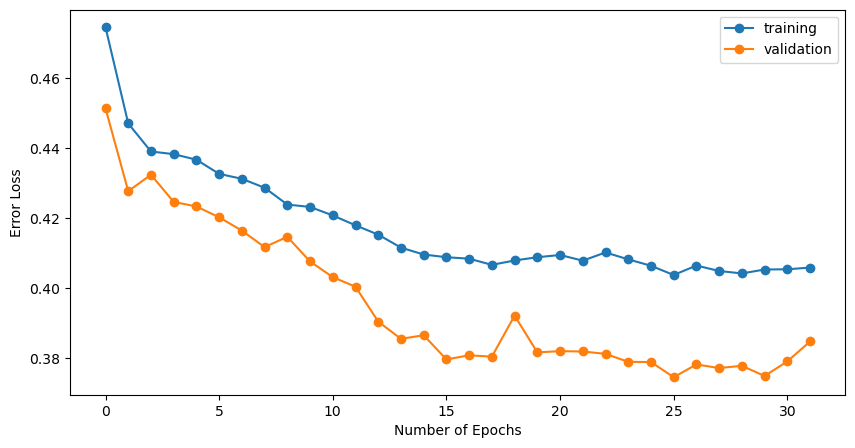

Trianing Recall Macro Curve


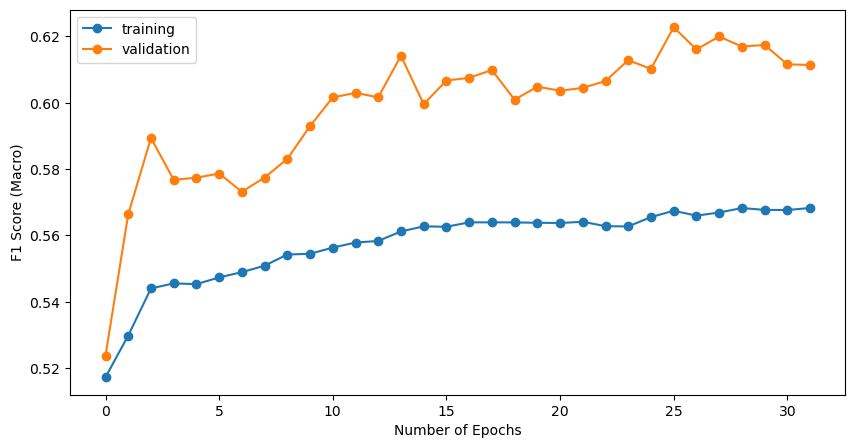

Recall (Macro)
0.6213615644384929
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.00      0.00      0.00       152
   dalmatian       0.00      0.00      0.00       442
        mole       0.00      0.00      0.00        75
     leopard       0.00      0.01      0.00       568
       moose       0.00      0.00      0.00       554
     gorilla       0.00      0.00      0.00       709
          ox       0.00      0.00      0.00       588
  chimpanzee       0.00      0.00      0.00       566
     hamster       0.00      0.00      0.00       640
      rabbit       0.00      0.00      0.00       877
 giant+panda       0.67      0.55      0.60       692
        deer       0.15      0.04      0.07      1069
     raccoon       0.04      0.21      0.06       408

    accuracy                           0.07      7340
   macro avg       0.07      0.06      0.06      7340
weighted avg       0.09      0.07      0.07      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.      

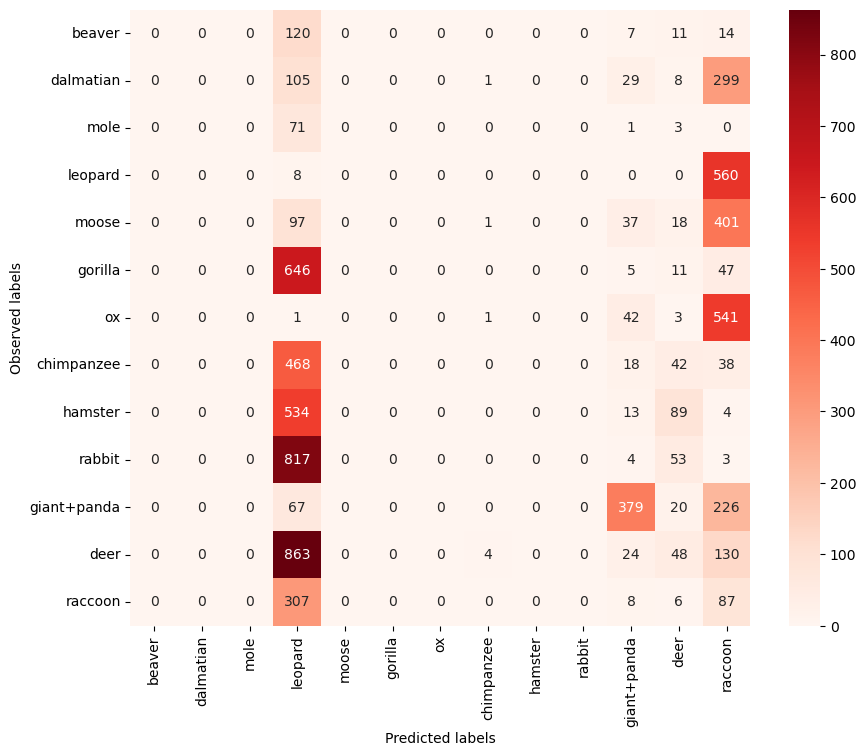

              precision    recall  f1-score   support

ARTIODACTYLA       0.22      0.03      0.05      2211
   CARNIVORA       0.30      0.98      0.45      2110
EULIPOTYPHLA       0.00      0.00      0.00        75
  LAGOMORPHA       0.00      0.00      0.00       877
    PRIMATES       0.00      0.00      0.00      1275
    RODENTIA       0.00      0.00      0.00       792

    accuracy                           0.29      7340
   macro avg       0.09      0.17      0.08      7340
weighted avg       0.15      0.29      0.15      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.0312076  0.98341232 0.         0.         0.         0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.1691033201077765


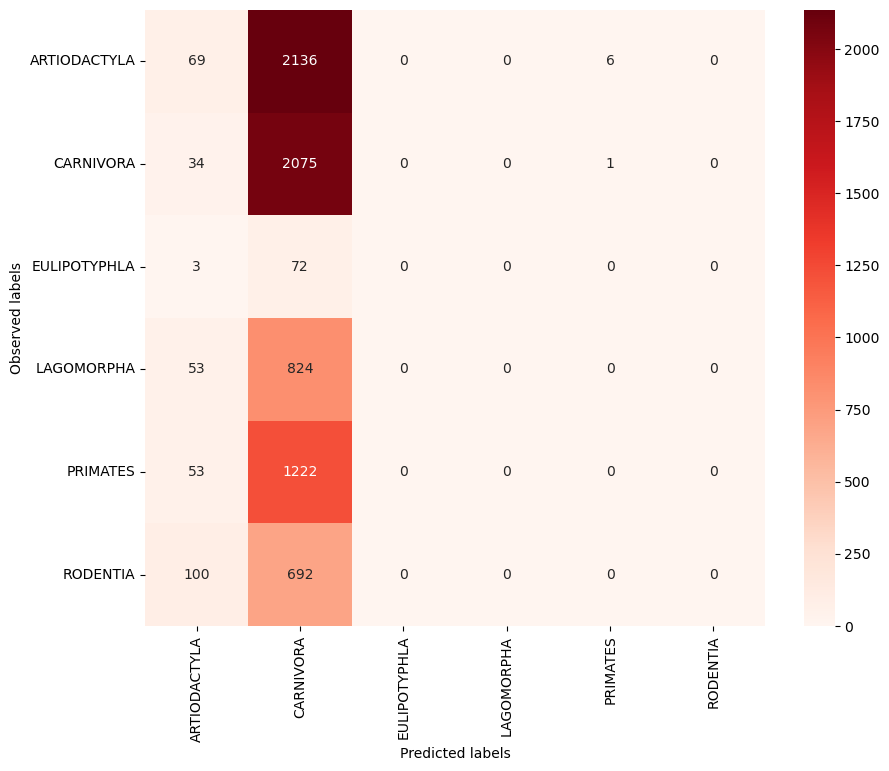

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.15195239771867294 
              0         1
0        beaver  0.019737
1     dalmatian  0.015837
2          mole  0.000000
3       leopard  0.038732
4         moose  0.000000
5       gorilla  0.000000
6            ox  0.000000
7    chimpanzee  0.044170
8       hamster  0.000000
9        rabbit  0.000000
10  giant+panda  0.838150
11         deer  0.793265
12      raccoon  0.225490 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.23298610299670608 
              0         1
0        beaver  0.078947
1     dalmatian  0.015837
2          mole  0.000000
3       leopard  0.040493
4         moose  0.003610
5       gorilla  0.000000
6            ox  0.000000
7    chimpanzee  0.902827
8       hamster  0.021875
9        rabbit  0.000000
10  giant+panda  0.880058
11         deer  0.859682
12      raccoon  0.225490 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.27047931174721057 
              0         1
0        beaver  0.078947
1  

In [22]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork2, 
               epochs = 32, 
               bs = 17, 
               numunits = 0, 
               lr = 0.4753993508431557, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.33401468018301217, 
               mom = 0.9568309306033719, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4495                0.5167        0.4360                0.5152     +  1.5479
      2        0.4314                0.5178        0.4153                0.5256     +  1.3588
      3        0.4221                0.5287        0.4034                0.5560     +  1.3299
      4        0.4184                0.5386        0.3979                0.5653     +  1.3553
      5        0.4103                0.5481        0.3979                0.5663        1.3572
      6        0.4083                0.5502        0.3991                0.5577        1.6259
      7        0.4074                0.5508        0.3982                0.5653        1.5644
      8        0.4060                0.5525        0.3969                0.5707     +  1.5956
      9        0.4060                0.5530    

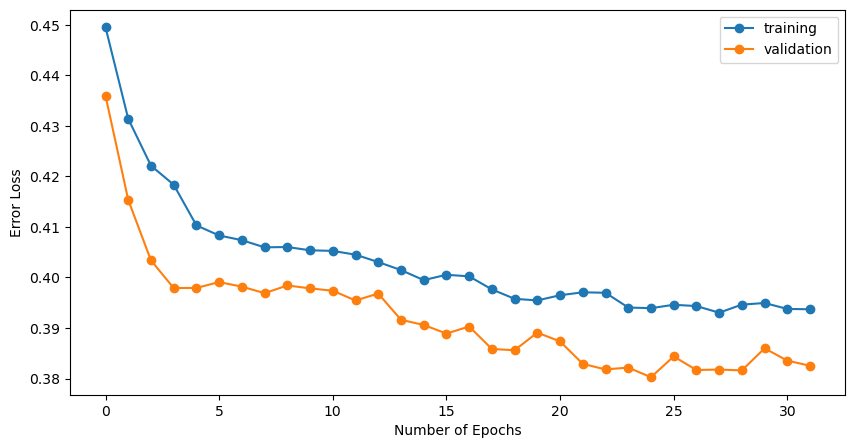

Trianing Recall Macro Curve


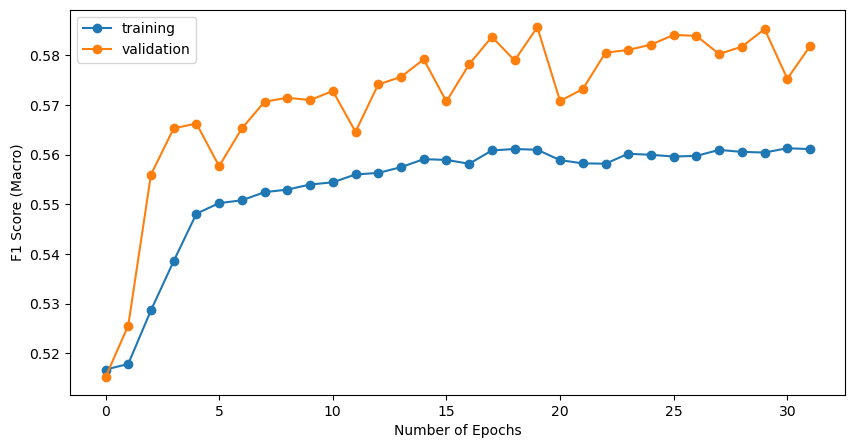

Recall (Macro)
0.5814788194952449
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.00      0.00      0.00       864
grizzly+bear       0.00      0.00      0.00       690
killer+whale       0.00      0.00      0.00       231
      beaver       0.00      0.00      0.00       152
   dalmatian       0.00      0.00      0.00       442
 persian+cat       0.37      0.86      0.51       599
       skunk       0.10      0.68      0.17       157
          ox       0.00      0.00      0.00       588
         fox       0.00      0.00      0.00       540
   chihuahua       0.00      0.00      0.00       448
       otter       0.13      0.61      0.21       592
       zebra       0.00      0.00      0.00       942
         pig       0.06      0.16      0.09       558

    accuracy                           0.16      6803
   macro avg       0.05      0.18      0.08      6803
weighted avg       0.05      0.16      0.07      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.      

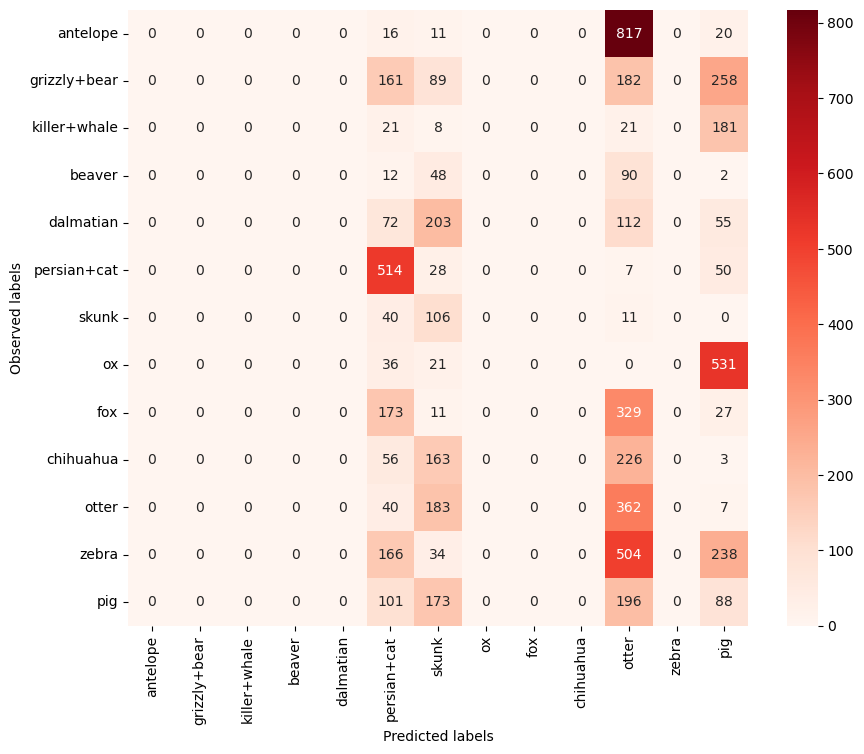

                precision    recall  f1-score   support

  ARTIODACTYLA       0.56      0.37      0.44      2241
     CARNIVORA       0.57      0.88      0.70      3468
PERISSODACTYLA       0.00      0.00      0.00       942
      RODENTIA       0.00      0.00      0.00       152

      accuracy                           0.57      6803
     macro avg       0.28      0.31      0.28      6803
  weighted avg       0.48      0.57      0.50      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.36590808 0.88465975 0.         0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.312641955750723


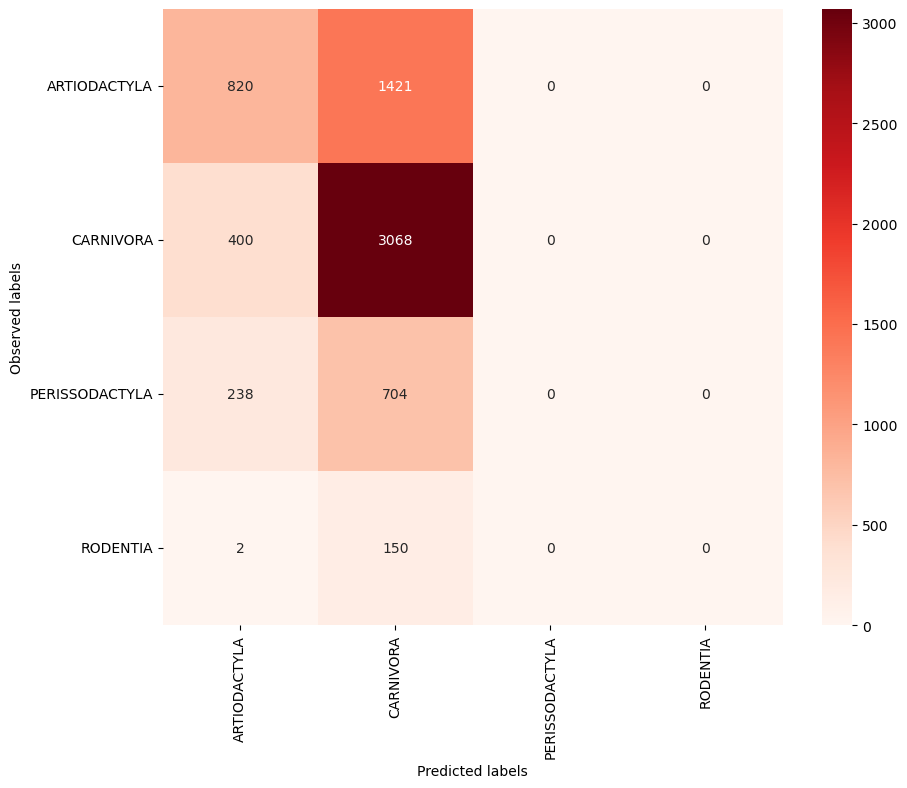

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.21488438665411266 
               0         1
0       antelope  0.000000
1   grizzly+bear  0.000000
2   killer+whale  0.000000
3         beaver  0.019737
4      dalmatian  0.000000
5    persian+cat  0.869783
6          skunk  0.777070
7             ox  0.000000
8            fox  0.000000
9      chihuahua  0.000000
10         otter  0.917230
11         zebra  0.000000
12           pig  0.209677 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.3129669176132899 
               0         1
0       antelope  0.001157
1   grizzly+bear  0.355072
2   killer+whale  0.004329
3         beaver  0.019737
4      dalmatian  0.667421
5    persian+cat  0.869783
6          skunk  1.000000
7             ox  0.000000
8            fox  0.000000
9      chihuahua  0.000000
10         otter  0.932432
11         zebra  0.000000
12           pig  0.218638 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.39706016501434005 
               0         1
0

In [23]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork2, 
               epochs = 32, 
               bs = 17, 
               numunits = 0, 
               lr = 0.4753993508431557, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.33401468018301217, 
               mom = 0.9568309306033719, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4550                0.5034        0.4175                0.5174     +  1.8226
      2        0.4178                0.5228        0.3961                0.5584     +  1.6440
      3        0.4132                0.5335        0.3985                0.5465        1.5315
      4        0.4083                0.5368        0.3968                0.5584        1.3655
      5        0.4051                0.5411        0.3958                0.5763     +  1.4807
      6        0.4050                0.5416        0.4009                0.5760        1.4846
      7        0.4049                0.5416        0.3986                0.5751        1.6127
      8        0.4026                0.5440        0.3951                0.5853     +  1.6033
      9        0.4018                0.5456    

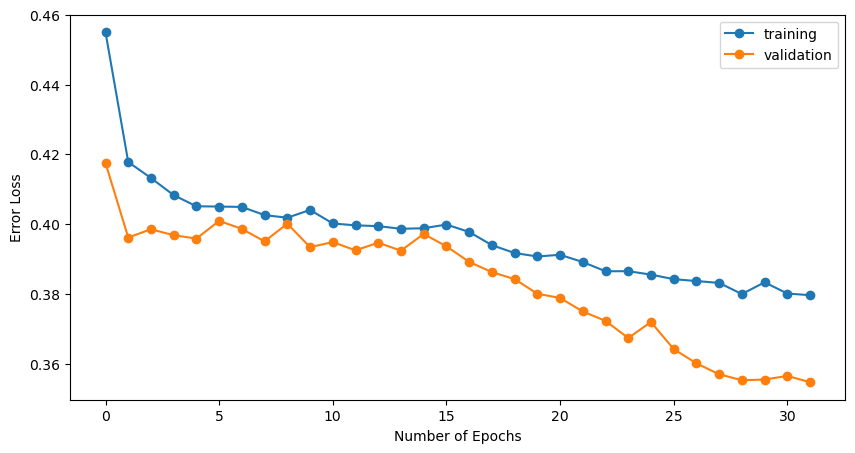

Trianing Recall Macro Curve


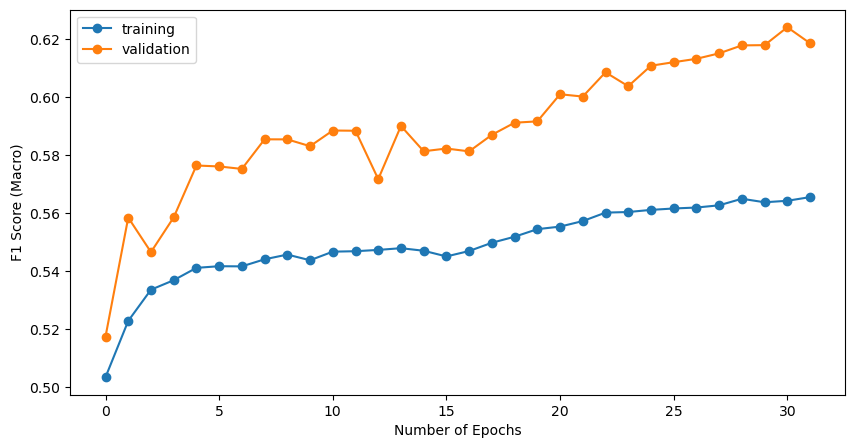

Recall (Macro)
0.6169605268083075
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.00      0.00      0.00       400
         moose       0.00      0.00      0.00       554
humpback+whale       0.00      0.00      0.00       565
    chimpanzee       0.08      0.52      0.14       566
      squirrel       0.00      0.00      0.00       961
    rhinoceros       0.00      0.00      0.00       561
        rabbit       0.00      0.00      0.00       877
          wolf       0.06      0.00      0.00       470
     chihuahua       0.00      0.00      0.00       448
        weasel       0.01      0.15      0.03       222
   giant+panda       0.11      0.01      0.01       692
           pig       0.00      0.00      0.00       558
       raccoon       0.01      0.00      0.00       408

      accuracy                           0.05      7282
     macro avg       0.02      0.05      0.01      7282
  weighted avg       0.02      0.05      0.01      7282

Top_1_accuracy for UnSeen Validation split 01

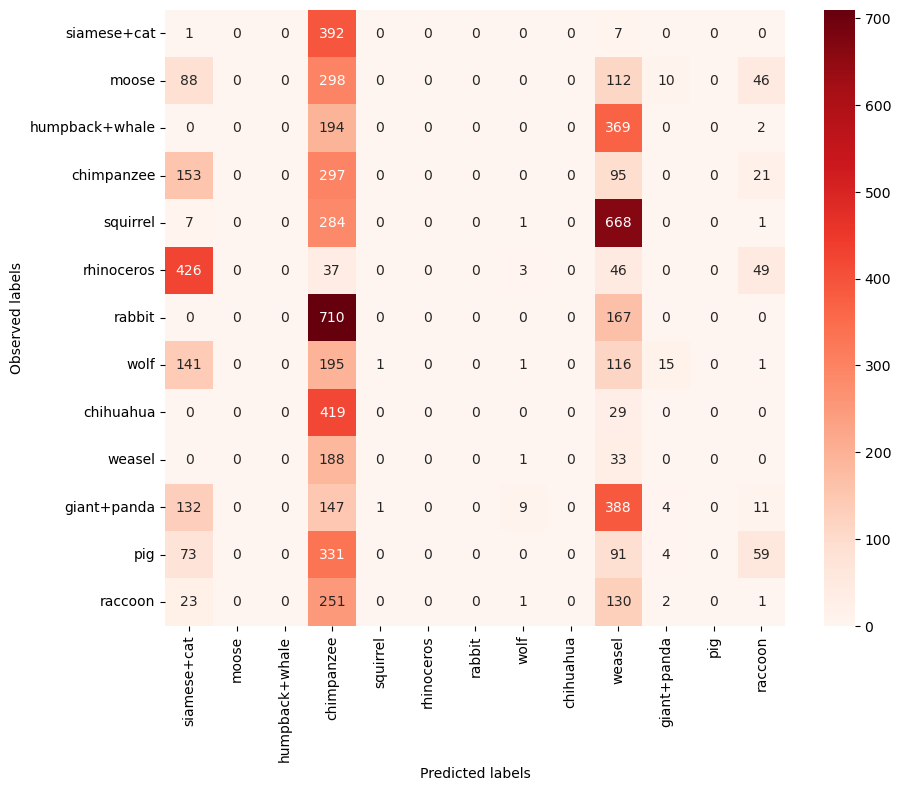

                precision    recall  f1-score   support

  ARTIODACTYLA       0.00      0.00      0.00      1677
     CARNIVORA       0.30      0.40      0.34      2640
    LAGOMORPHA       0.00      0.00      0.00       877
PERISSODACTYLA       0.00      0.00      0.00       561
      PRIMATES       0.08      0.52      0.14       566
      RODENTIA       0.00      0.00      0.00       961

      accuracy                           0.18      7282
     macro avg       0.06      0.15      0.08      7282
  weighted avg       0.11      0.18      0.13      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.39621212 0.         0.         0.52473498 0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.15349118392404612


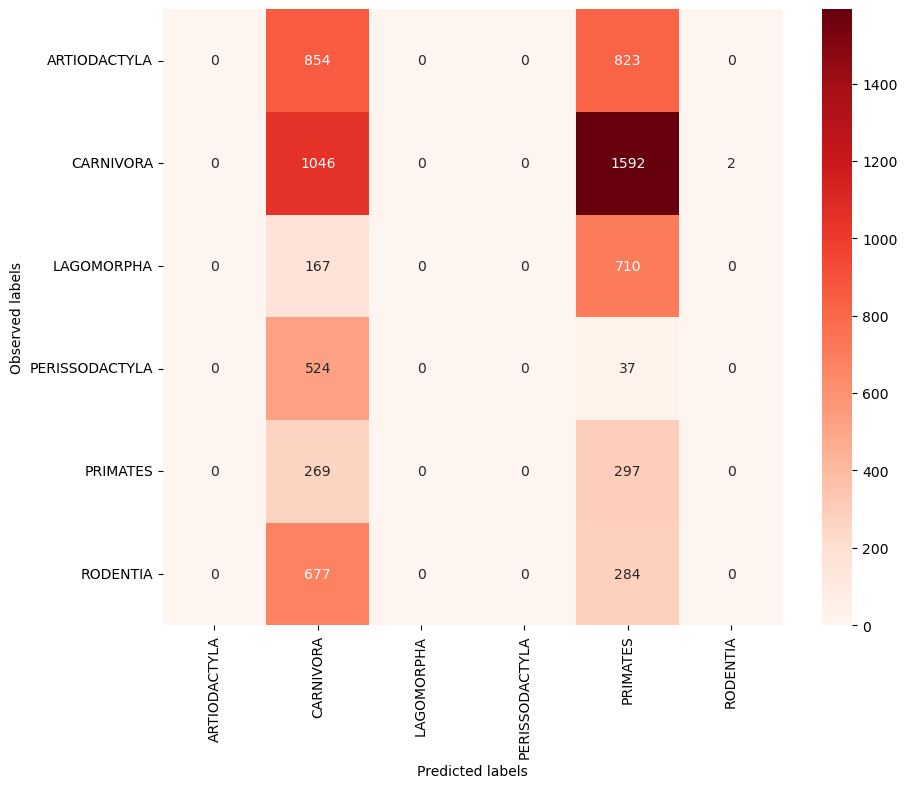

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.1414940653148237 
                 0         1
0      siamese+cat  0.002500
1            moose  0.032491
2   humpback+whale  0.000000
3       chimpanzee  0.597173
4         squirrel  0.003122
5       rhinoceros  0.000000
6           rabbit  0.000000
7             wolf  0.002128
8        chihuahua  0.917411
9           weasel  0.157658
10     giant+panda  0.028902
11             pig  0.000000
12         raccoon  0.098039 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.24152082642694822 
                 0         1
0      siamese+cat  0.002500
1            moose  0.041516
2   humpback+whale  0.000000
3       chimpanzee  0.676678
4         squirrel  0.896982
5       rhinoceros  0.000000
6           rabbit  0.000000
7             wolf  0.276596
8        chihuahua  0.933036
9           weasel  0.180180
10     giant+panda  0.031792
11             pig  0.000000
12         raccoon  0.100490 

 Top- 4  Accuracy per class 
 Top- 4  Accur

In [24]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork2, 
               epochs = 32, 
               bs = 17, 
               numunits = 0, 
               lr = 0.4753993508431557, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.33401468018301217, 
               mom = 0.9568309306033719, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4558                0.5155        0.4338                0.5227     +  2.2381
      2        0.4375                0.5248        0.4197                0.5506     +  2.1545
      3        0.4309                0.5345        0.4178                0.5651     +  2.1113
      4        0.4289                0.5390        0.4192                0.5702        2.2398
      5        0.4272                0.5415        0.4163                0.5686     +  2.1191
      6        0.4259                0.5418        0.4178                0.5671        2.1711
      7        0.4254                0.5413        0.4174                0.5717        2.2107
      8        0.4223                0.5444        0.4170                0.5736        2.1148
      9        0.4200                0.5435    

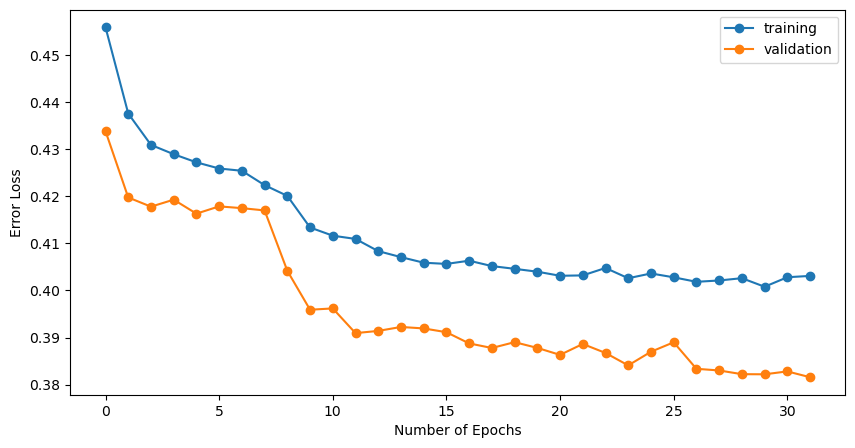

Trianing Recall Macro Curve


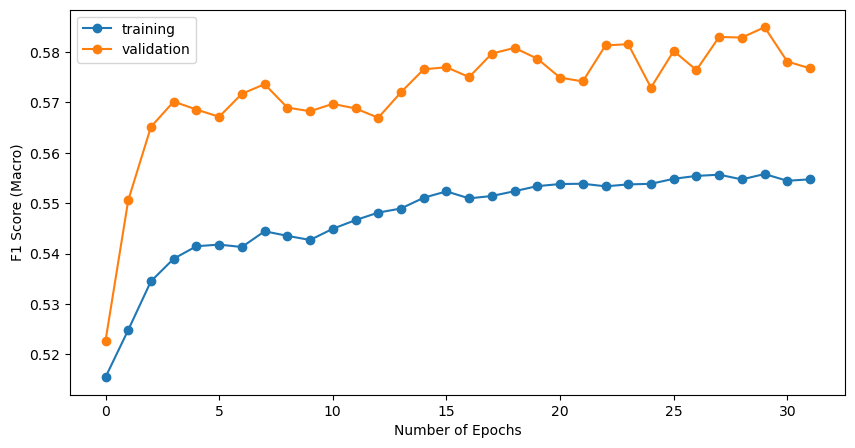

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.00      0.00      0.00      1645
  blue+whale       0.00      0.00      0.00       174
       sheep       0.00      0.00      0.00      1420
        seal       0.17      0.19      0.17       988
         bat       0.14      0.00      0.01       383
     giraffe       0.00      0.00      0.00      1202
         rat       0.00      0.01      0.00       310
      bobcat       0.81      0.13      0.22       630
      walrus       0.02      0.20      0.03       215
     dolphin       0.00      0.00      0.00       946

    accuracy                           0.04      7913
   macro avg       0.11      0.05      0.04      7913
weighted avg       0.09      0.04      0.04      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.         0.         0.18522267 0.00261097 0.
 0.00645161 0.12857143 0.2        0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.052285667959687296


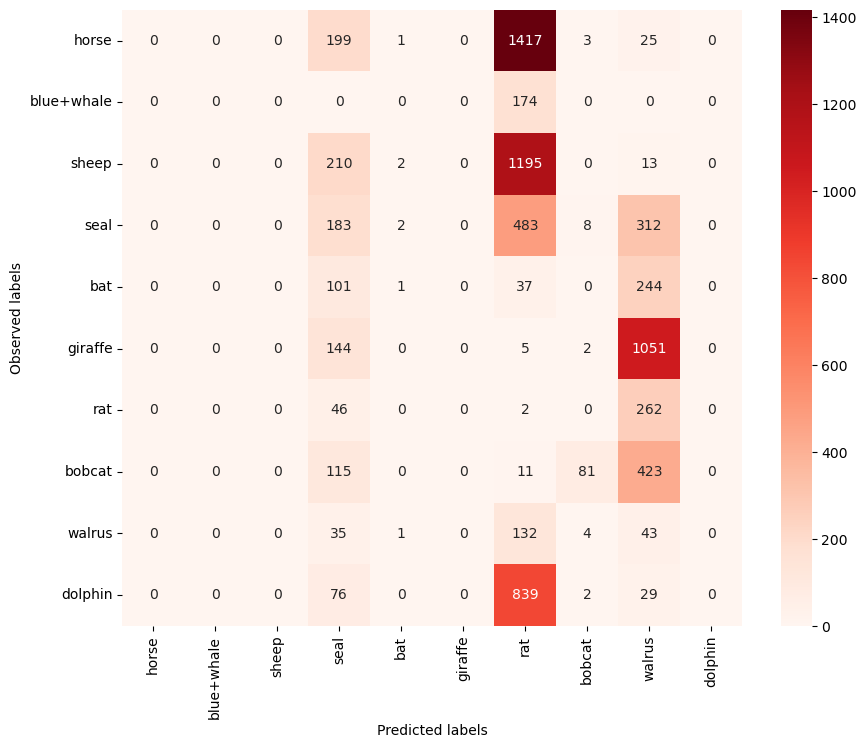

                precision    recall  f1-score   support

  ARTIODACTYLA       0.00      0.00      0.00      3742
     CARNIVORA       0.33      0.66      0.44      1833
    CHIROPTERA       0.14      0.00      0.01       383
PERISSODACTYLA       0.00      0.00      0.00      1645
      RODENTIA       0.00      0.01      0.00       310

      accuracy                           0.15      7913
     macro avg       0.10      0.13      0.09      7913
  weighted avg       0.08      0.15      0.10      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.6568467  0.00261097 0.         0.00645161]
Top_1_accuracy for UnSeen Validation split 01 -  0.1331818556721116


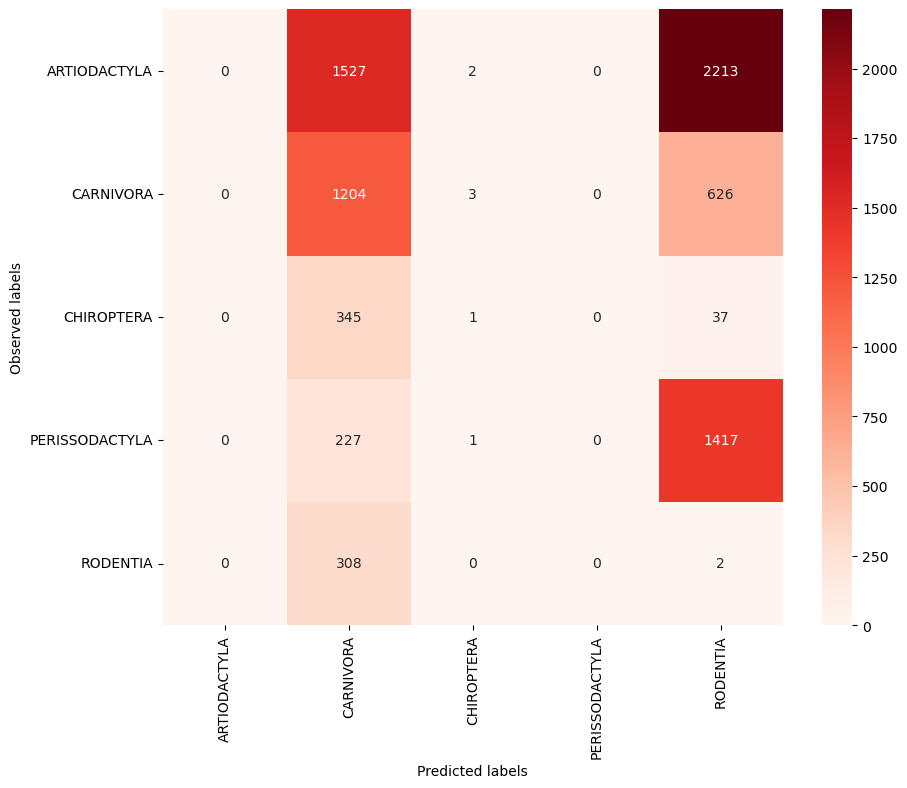

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.11115392042915544 
            0         1
0       horse  0.000000
1  blue+whale  0.000000
2       sheep  0.000000
3        seal  0.612348
4         bat  0.026110
5     giraffe  0.000000
6         rat  0.006452
7      bobcat  0.131746
8      walrus  0.334884
9     dolphin  0.000000 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.3152115214609693 
            0         1
0       horse  0.000000
1  blue+whale  0.000000
2       sheep  0.000000
3        seal  0.718623
4         bat  0.028721
5     giraffe  0.000000
6         rat  0.996774
7      bobcat  0.165079
8      walrus  0.497674
9     dolphin  0.745243 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.44397104444219443 
            0         1
0       horse  0.000000
1  blue+whale  0.000000
2       sheep  0.002817
3        seal  0.989879
4         bat  1.000000
5     giraffe  0.000000
6         rat  1.000000
7      bobcat  0.176190
8      walrus  0.502326
9     dolphin  0

In [25]:
Test01 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork2, 
               epochs = 32, 
               bs = 17, 
               numunits = 0, 
               lr = 0.4753993508431557, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.33401468018301217, 
               mom = 0.9568309306033719, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

 # 11. CZSL on Unseen Test Set using non optimised parameters

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4435                0.5179        0.4217                0.5269     +  2.2377
      2        0.4043                0.5364        0.3821                0.5527     +  2.2871
      3        0.3639                0.5738        0.3439                0.5917     +  2.1668
      4        0.3291                0.6151        0.3131                0.6362     +  1.9803
      5        0.3013                0.6585        0.2882                0.6761     +  2.0417
      6        0.2785                0.6933        0.2676                0.7082     +  2.0060
      7        0.2597                0.7218        0.2504                0.7361     +  2.4570
      8        0.2438                0.7466        0.2357                0.7589     +  1.7715
      9        0.2302                0.7676    

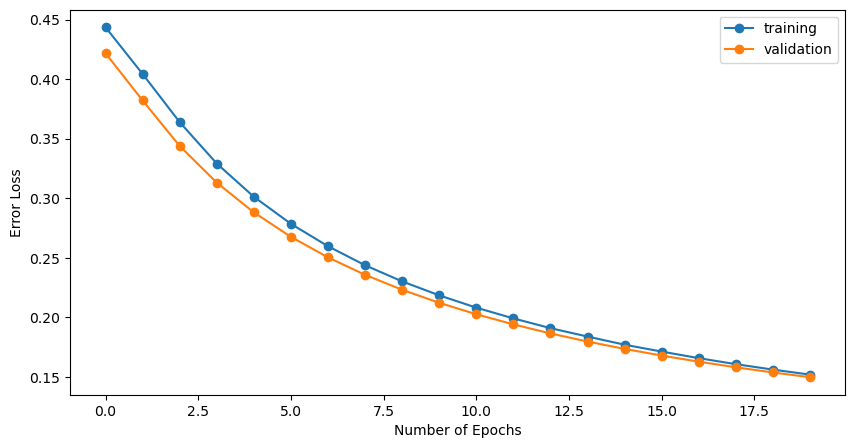

Trianing Recall Macro Curve


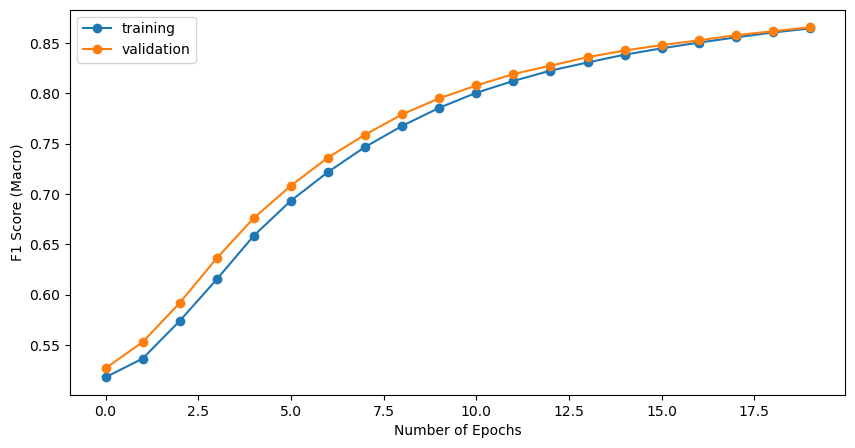

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.00      0.00      0.00      1645
  blue+whale       0.00      0.00      0.00       174
       sheep       0.00      0.00      0.00      1420
        seal       0.19      0.64      0.30       988
         bat       0.04      0.11      0.06       383
     giraffe       0.00      0.00      0.00      1202
         rat       0.03      0.16      0.04       310
      bobcat       1.00      0.02      0.04       630
      walrus       0.01      0.07      0.02       215
     dolphin       0.68      0.42      0.52       946

    accuracy                           0.15      7913
   macro avg       0.20      0.14      0.10      7913
weighted avg       0.19      0.15      0.11      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.         0.         0.64068826 0.10704961 0.
 0.16451613 0.02063492 0.06976744 0.42389006]
Top_1_accuracy for UnSeen Validation split 01 -  0.14265464224169938


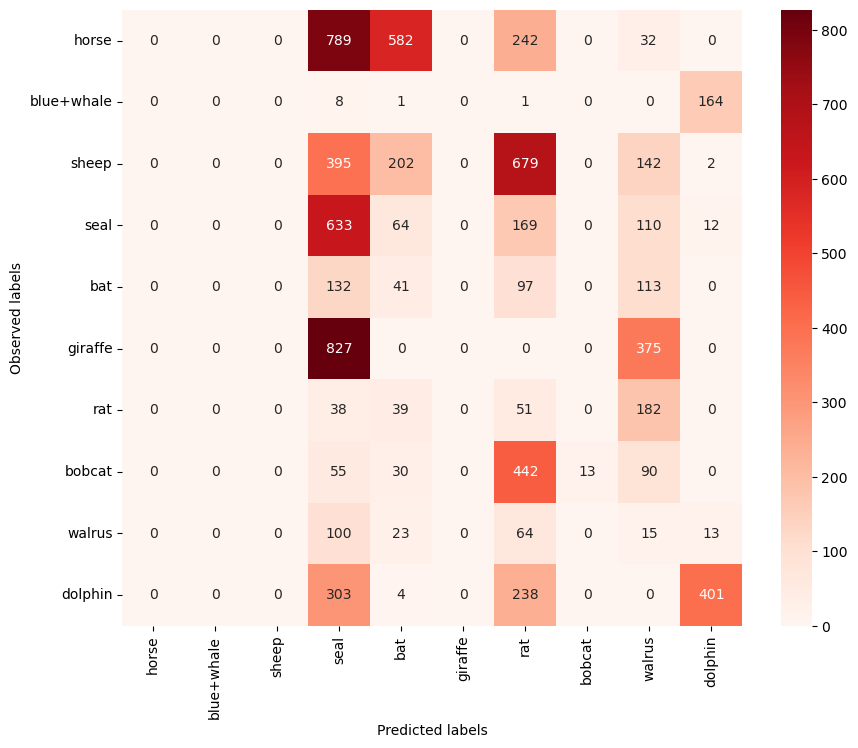

                precision    recall  f1-score   support

  ARTIODACTYLA       0.96      0.15      0.26      3742
     CARNIVORA       0.23      0.55      0.33      1833
    CHIROPTERA       0.04      0.11      0.06       383
PERISSODACTYLA       0.00      0.00      0.00      1645
      RODENTIA       0.03      0.16      0.04       310

      accuracy                           0.21      7913
     macro avg       0.25      0.20      0.14      7913
  weighted avg       0.51      0.21      0.20      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.15152325 0.5542826  0.10704961 0.         0.16451613]
Top_1_accuracy for UnSeen Validation split 01 -  0.19547431676445653


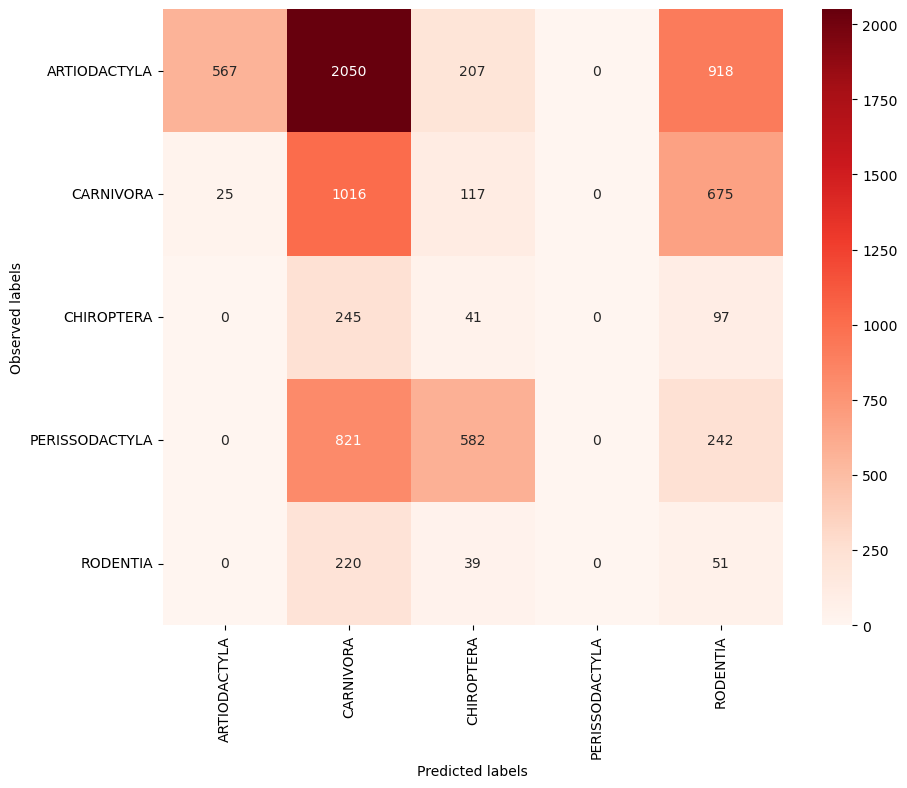

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.24922948965677133 
            0         1
0       horse  0.000000
1  blue+whale  0.000000
2       sheep  0.000000
3        seal  0.822874
4         bat  0.284595
5     giraffe  0.000000
6         rat  0.312903
7      bobcat  0.038095
8      walrus  0.418605
9     dolphin  0.615222 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.3716694879048855 
            0         1
0       horse  0.000000
1  blue+whale  0.000000
2       sheep  0.001408
3        seal  0.931174
4         bat  0.360313
5     giraffe  0.000000
6         rat  0.948387
7      bobcat  0.139683
8      walrus  0.553488
9     dolphin  0.782241 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.46601308924369356 
            0         1
0       horse  0.000000
1  blue+whale  0.000000
2       sheep  0.011972
3        seal  0.985830
4         bat  0.778068
5     giraffe  0.000000
6         rat  1.000000
7      bobcat  0.211111
8      walrus  0.706977
9     dolphin  0

In [26]:
Test02 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard